<a href="https://colab.research.google.com/github/Vinaypatil-Ev/vinEvPy-GoCoLab/blob/main/Tensorflow/TensorflowPrac21_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural network (RNN)

In [1]:
import tensorflow as tf

In [2]:
def input_model():
    return tf.keras.Sequential([
            tf.keras.layers.Embedding(100, 64),
            tf.keras.layers.LSTM(123),
            tf.keras.layers.Dense(10)
    ])

In [3]:
input_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          6400      
_________________________________________________________________
lstm (LSTM)                  (None, 123)               92496     
_________________________________________________________________
dense (Dense)                (None, 10)                1240      
Total params: 100,136
Trainable params: 100,136
Non-trainable params: 0
_________________________________________________________________


In [4]:
def output_model():
    return tf.keras.Sequential([
            tf.keras.layers.Embedding(1000, 64),
            tf.keras.layers.GRU(256, return_sequences=True),
            tf.keras.layers.SimpleRNN(128),
            tf.keras.layers.Dense(10),
    ])

In [5]:
output_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 256)         247296    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


In [6]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = tf.keras.Input(shape=(None, ))
encoder_embedded = tf.keras.layers.Embedding(encoder_vocab, 64)(encoder_input)

output, _h, _c = tf.keras.layers.LSTM(64, return_state=True, name="encoder")(encoder_embedded)
encoder_state = [_h, _c]

decoder_input = tf.keras.Input(shape=(None, ))
decoder_embedding = tf.keras.layers.Embedding(decoder_vocab, 64)(decoder_input)

decoder_output = tf.keras.layers.LSTM(64, name="decoder")(decoder_embedding, initial_state=encoder_state)

ouput = tf.keras.layers.Dense(10)(decoder_output)

model = tf.keras.Model([encoder_input, decoder_input], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     64000       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 64), (None,  33024       embedding_2[0][0]                
Total params: 97,024
Trainable params: 97,024
Non-trainable params: 0
________________________

#RNN layers and RNN cells

### RNN layers processes whole batch of input sequences while RNN cell processes only single timestep
### There are three buit in RNN cells
####1. *tf.keras.layers.SimpleRNNCell()*
####2. *tf.keras.layers.GRUCell()*
####3. *tf.keras.layers.LSTMCell()*

### Cross Batch statefullness
#### It is used when input sequence is of infinte length
#### If you have very long sequence, it is useful to break the sequence into subsequences
#### But for every new batch as input to RNN, internal state of RNN layer is get reset 
#### To feed these subsequences of input without reseting internal state RNN you need set 
#### *stateful = True* 


In [7]:
tensor = tf.random.normal([64, 10, 10])
seq = tf.data.Dataset.from_tensor_slices(tensor).batch(4)
[i.shape for i in seq]

[TensorShape([4, 10, 10]),
 TensorShape([4, 10, 10]),
 TensorShape([4, 10, 10]),
 TensorShape([4, 10, 10]),
 TensorShape([4, 10, 10]),
 TensorShape([4, 10, 10]),
 TensorShape([4, 10, 10]),
 TensorShape([4, 10, 10]),
 TensorShape([4, 10, 10]),
 TensorShape([4, 10, 10]),
 TensorShape([4, 10, 10]),
 TensorShape([4, 10, 10]),
 TensorShape([4, 10, 10]),
 TensorShape([4, 10, 10]),
 TensorShape([4, 10, 10]),
 TensorShape([4, 10, 10])]

In [8]:
lstm_layer = tf.keras.layers.LSTM(64, stateful=True,)
for i in seq:
    output = lstm_layer(i)

### you can reset the state after feeding all subsequeces by calling *reset_states()*

In [9]:
# lstm_layer.reset_states()

### Reuse RNN states

In [10]:
existing_states = lstm_layer.states

In [11]:
seq = tf.random.normal([4, 10, 10])

In [12]:
new_lstm_layer = tf.keras.layers.LSTM(64)
new_output = new_lstm_layer(seq, initial_state=existing_states)

### Bidirectional RNN



In [13]:
model = tf.keras.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), input_shape=(5, 10)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(10),
])

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 128)            38400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


### Using CuDnn kernerl in RNN

In [15]:
batch_size = 64
input_dim = 28
units = 64
output_shape = 10
def build_model(allow_cudnn_kernel=True):
    if allow_cudnn_kernel:
        print("with Gpu")
        lstm_layer = tf.keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        lstm_layer = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(units), input_shape=(None, input_dim))

    model = tf.keras.models.Sequential([
            lstm_layer,
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(output_shape)
            ])
    return model

In [16]:
(xtrn, ytrn), (xtst, ytst) = tf.keras.datasets.mnist.load_data()
xtrn, ytrn = xtrn / 255.0, ytrn / 255.0


11493376/11490434 [==============================] - 0s 0us/step


In [17]:
model = build_model(True)
model.compile(optimizer="sgd", 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(True),
              metrics=["acc"]
              )
model.fit(xtrn, ytrn, validation_data=(xtst, ytst), batch_size=batch_size)

with Gpu
938/938 [==============================] - 8s 5ms/step - loss: 0.5824 - acc: 0.0908 - val_loss: 10.7789 - val_acc: 0.1145


In [18]:
model = build_model(False)
model.set_weights(model.get_weights())
model.compile(optimizer="sgd", 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(True),
              metrics=["acc"]
              )
model.fit(xtrn, ytrn, validation_data=(xtst, ytst), batch_size=batch_size)

938/938 [==============================] - 43s 45ms/step - loss: 0.6510 - acc: 0.0911 - val_loss: 12.3868 - val_acc: 0.0824


In [19]:
import matplotlib.pyplot as plt
import numpy as np

In [20]:
with tf.device("CPU:0"):
    model = build_model(True)
    model.set_weights(model.get_weights())
    result = model.predict(tf.expand_dims(xtrn[0], 0))
    print(f"result {result}")
    print(tf.argmax(result, 1))
    print(np.argmax(result))

with Gpu
result [[ 0.02658391  0.00368165  0.06408019 -0.11469118 -0.03785234  0.10062922
  -0.05930409  0.18749768  0.02851194 -0.04000201]]
tf.Tensor([7], shape=(1,), dtype=int64)
7


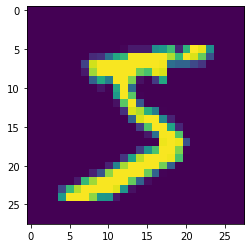

In [21]:
plt.imshow(xtrn[0])

In [88]:
class NestedCell(tf.keras.layers.Layer):
    def __init__(self, unit1, unit2, unit3, **kwargs):
        self.unit1 = unit1
        self.unit2 = unit2
        self.unit3 = unit3
        self.state_size = [tf.TensorShape([unit1]), tf.TensorShape([unit2, unit3])]
        self.output_size = [tf.TensorShape([unit1]), tf.TensorShape([unit2, unit3])]
        super(NestedCell, self).__init__(**kwargs)
    def build(self, input_shape):
        i1 = input_shape[0][1]
        i2 = input_shape[1][1]
        i3 = input_shape[1][2]
        self.kernel_1 = self.add_weight(shape=(i1, self.unit1), initializer="uniform", name="kernel_1")
        self.kernel_2_3 = self.add_weight(shape=(i2, i3, self.unit2, self.unit3), initializer="uniform", name="kernel_2_3")
    def call(self, inputs, states):
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states
        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_state = (state_1, state_2_3)
        return output, new_state
    def get_config(self):
        return {"unit1": self.unit1, "unit2": self.unit2, "unit3": self.unit3}

In [89]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32

batch_size = 64
num_batches = 10
timestep = 50

In [90]:
cell = NestedCell(unit_1, unit_2, unit_3)
rnn = tf.keras.layers.RNN(cell)

In [91]:
input_1 = tf.keras.Input((None, i1))
input_2 = tf.keras.Input((None, i2, i3))

In [92]:
outputs = rnn((input_1, input_2))

In [93]:
model = tf.keras.Model([input_1, input_2], outputs)

In [94]:
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

In [95]:
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))

In [96]:
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

In [97]:
model.fit(input_data, target_data, batch_size=batch_size)

10/10 [==============================] - 1s 38ms/step - loss: 0.8712 - rnn_9_loss: 0.2946 - rnn_9_1_loss: 0.5765 - rnn_9_accuracy: 0.0991 - rnn_9_1_accuracy: 0.0288
